In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [4]:
data = pd.read_csv("/kaggle/input/alibaba-gpu-cluster-dataset-2025/disaggregated_DLRM_trace.csv")
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (23871, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23871 entries, 0 to 23870
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   instance_sn            23871 non-null  object 
 1   role                   23871 non-null  object 
 2   app_name               23871 non-null  object 
 3   cpu_request            23871 non-null  int64  
 4   cpu_limit              23871 non-null  int64  
 5   gpu_request            23871 non-null  int64  
 6   gpu_limit              23871 non-null  int64  
 7   rdma_request           23871 non-null  int64  
 8   rdma_limit             23871 non-null  int64  
 9   memory_request         23871 non-null  float64
 10  memory_limit           23871 non-null  float64
 11  disk_request           23871 non-null  float64
 12  disk_limit             23871 non-null  float64
 13  max_instance_per_node  23871 non-null  int64  
 14  creation_time          16591 n

,instance_sn,role,app_name,cpu_request,cpu_limit,gpu_request,gpu_limit,rdma_request,rdma_limit,memory_request,memory_limit,disk_request,disk_limit,max_instance_per_node,creation_time,scheduled_time,deletion_time
0,instance_0,HN,app_0,12,12,1,1,25,25,120.0,120.0,640.0,800.0,8,NaN,NaN,NaN
1,instance_1,HN,app_0,12,12,1,1,25,25,120.0,120.0,680.0,800.0,8,NaN,NaN,NaN
2,instance_2,HN,app_0,12,12,1,1,25,25,120.0,120.0,680.0,800.0,8,NaN,NaN,NaN
3,instance_3,HN,app_0,12,12,1,1,25,25,120.0,120.0,640.0,800.0,8,NaN,NaN,NaN
4,instance_4,HN,app_0,12,12,1,1,25,25,120.0,120.0,640.0,800.0,8,NaN,NaN,NaN


In [5]:
# Checking for any duplicates in the dataset
data.duplicated().sum()

0

### Checking for missing values
Both creation_time and scheduled_time have exactly the same count rows of missing values, not useful for later Scheduling delay analysis, hence delete them.

However, rows with missing deletion_time are valuable for later Scheduling delay, as that were created and scheduled but not completed (still running or failed).

In [5]:

data.isnull().sum()

instance_sn                 0
role                        0
app_name                    0
cpu_request                 0
cpu_limit                   0
gpu_request                 0
gpu_limit                   0
rdma_request                0
rdma_limit                  0
memory_request              0
memory_limit                0
disk_request                0
disk_limit                  0
max_instance_per_node       0
creation_time            7280
scheduled_time           7280
deletion_time            8878
dtype: int64

### 

### Data Cleaning and Preprocessing

In [6]:
# drop rows missing creation_time or scheduled_time
data = data.dropna(subset=["creation_time", "scheduled_time"])

#mark rows with missing deletion_time as "still running"
data["is_running"] = data["deletion_time"].isna()

# convert to timedelta (relative to 0 = start of trace)
for col in ["creation_time", "scheduled_time", "deletion_time"]:
    data[col] = pd.to_timedelta(data[col], unit="s")
    
# scheduling delay (in seconds)
data["scheduling_delay"] = (data["scheduled_time"] - data["creation_time"]).dt.total_seconds()

# runtime (in seconds)
data["runtime"] = (data["deletion_time"] - data["scheduled_time"]).dt.total_seconds()

print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (16591, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 16591 entries, 7280 to 23870
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   instance_sn            16591 non-null  object         
 1   role                   16591 non-null  object         
 2   app_name               16591 non-null  object         
 3   cpu_request            16591 non-null  int64          
 4   cpu_limit              16591 non-null  int64          
 5   gpu_request            16591 non-null  int64          
 6   gpu_limit              16591 non-null  int64          
 7   rdma_request           16591 non-null  int64          
 8   rdma_limit             16591 non-null  int64          
 9   memory_request         16591 non-null  float64        
 10  memory_limit           16591 non-null  float64        
 11  disk_request           16591 non-null  float64        
 12  disk_limit             1

,instance_sn,role,app_name,cpu_request,cpu_limit,gpu_request,gpu_limit,rdma_request,rdma_limit,memory_request,memory_limit,disk_request,disk_limit,max_instance_per_node,creation_time,scheduled_time,deletion_time,is_running,scheduling_delay,runtime
7280,instance_7280,CN,app_22,64,64,0,0,1,1,320.0,320.0,544.0,640.0,-1,0 days 00:07:55,0 days 00:10:23,NaT,True,148.0,NaN
7281,instance_7281,CN,app_88,64,64,0,0,1,1,320.0,320.0,255.0,300.0,-1,0 days 00:10:10,0 days 00:11:23,1 days 01:28:50,False,73.0,91047.0
7282,instance_7282,CN,app_88,64,64,0,0,1,1,320.0,320.0,255.0,300.0,-1,0 days 00:07:55,0 days 00:11:23,NaT,True,208.0,NaN
7283,instance_7283,CN,app_0,48,48,0,0,25,25,240.0,240.0,680.0,800.0,-1,0 days 00:07:55,0 days 00:07:55,NaT,True,0.0,NaN
7284,instance_7284,CN,app_46,96,96,0,0,1,1,480.0,480.0,255.0,300.0,-1,0 days 00:07:55,0 days 00:07:55,0 days 00:47:23,False,0.0,2368.0


### Whats the average Scheduling delay and Runtime per Instance?
Instances wait a short time in the queue before starting (about 3 mins 13 secs), and run for a long time once scheduled (about 28 hrs 46 mins), indicating that the system spends far more time on execution than on queue waiting.

In [7]:
# Average scheduling delay changed to minutes
avg_delay = data["scheduling_delay"].mean()/60


# Average runtime changed to minutes
avg_runtime = data.loc[data["is_running"] == False, "runtime"].mean()/60

print("Avg delay min:", avg_delay)
print("Avg runtime min:",avg_runtime)

avg_runtime_hr = avg_runtime / 60
print("Avg runtime (hours):", avg_runtime_hr)

Avg delay min: 3.1321238422437867
Avg runtime min: 1708.182874630078
Avg runtime (hours): 28.469714577167966


### How long do different types of nodes wait and run instances?
Head Nodes have higher average scheduling delays, showing they wait longer before starting instances, likely because they are more loaded. 

Compute Nodes have higher average runtimes, indicating they execute heaviera and longer running instances.




role
HN    505.327703
CN     78.170993
Name: scheduling_delay, dtype: float64
role
CN    109708.382795
HN     81919.783095
Name: runtime, dtype: float64


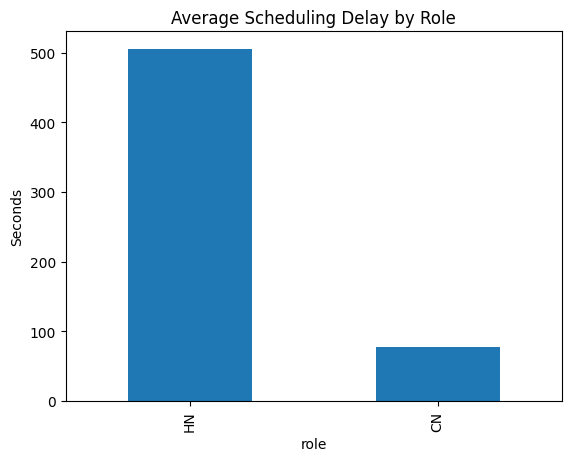

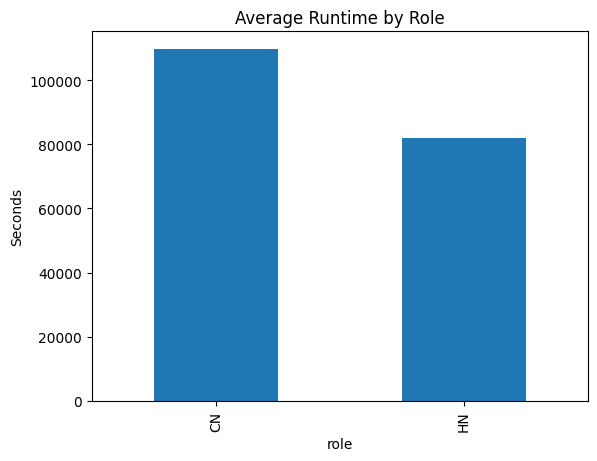

In [8]:
# Average scheduling delay by role
role_delay = data.groupby("role")["scheduling_delay"].mean().sort_values(ascending=False)
print(role_delay)

# Average runtime by role (finished instances only)
role_runtime = data.loc[data["is_running"]==False].groupby("role")["runtime"].mean().sort_values(ascending=False)
print(role_runtime)

# Plot scheduling delay by role
role_delay.plot(kind="bar", title="Average Scheduling Delay by Role", ylabel="Seconds")
plt.show()

# Plot runtime by role
role_runtime.plot(kind="bar", title="Average Runtime by Role", ylabel="Seconds")
plt.show()

### How long do instances from top applications wait and run?
Apps 153 and 76 experience significantly longer scheduling delays, suggesting they may require more resources.

App 116 stands out with the longest runtimes, showing it is resource-intensive, while a few other apps also have long runtimes to a lesser extent, but still worth noticing.
.




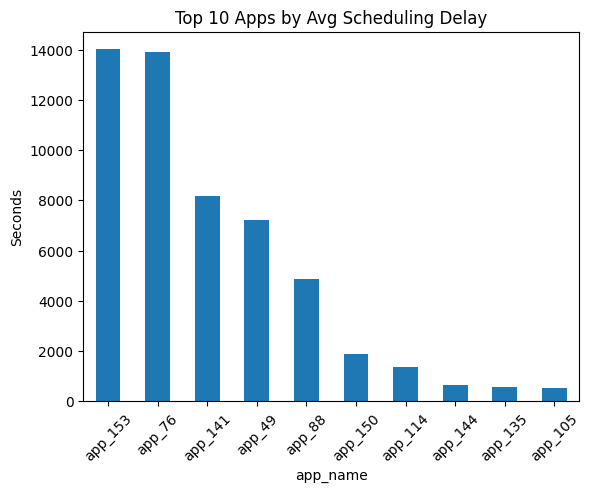

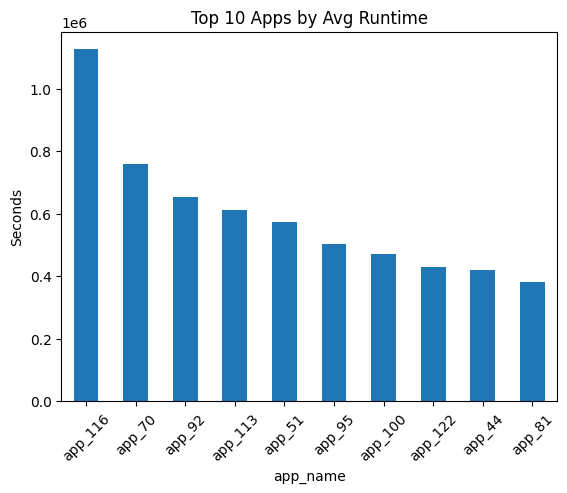

In [9]:
# Top 10 apps by average scheduling delay
top_apps_delay = data.groupby("app_name")["scheduling_delay"].mean().sort_values(ascending=False).head(10)

# Top 10 apps by average runtime (finished jobs only)
top_apps_runtime = data.loc[data["is_running"]==False].groupby("app_name")["runtime"].mean().sort_values(ascending=False).head(10)

# Plot top 10 apps by scheduling delay
top_apps_delay.plot(kind="bar", title="Top 10 Apps by Avg Scheduling Delay", ylabel="Seconds")
plt.xticks(rotation=45)
plt.show()

# Plot top 10 apps by runtime
top_apps_runtime.plot(kind="bar", title="Top 10 Apps by Avg Runtime", ylabel="Seconds")
plt.xticks(rotation=45)
plt.show()

### How efficiently are resources being allocated?
CPU, GPU, memory and RDMA requests exactly match their limits, showing no over-provisioning and efficient allocation(no wastage).
However Disk has an efficiency of about 0.85, meaning instances typically request about 85% of their disk limit and the rest capacity is left unallocated.

In [10]:
for resource in ["cpu", "gpu", "memory", "disk","rdma"]:
    data[f"{resource}_efficiency"] = data[f"{resource}_request"] / data[f"{resource}_limit"]

# Average efficiency across the cluster
efficiency_summary = data[[col for col in data.columns if "efficiency" in col]].mean()
print(efficiency_summary)

cpu_efficiency       1.000000
gpu_efficiency       1.000000
memory_efficiency    1.000000
disk_efficiency      0.851083
rdma_efficiency      1.000000
dtype: float64


### Which roles request more than they use?
Both Compute and Head Nodes allocate CPU, memory and RDMA efficiently, with requests exactly matching limits.
Only Head Nodes use GPUs request and its exactly their limit, no wastage.

Compute Nodes request an average of 85% efficiency while Head Nodes average 87%, of their disk limit, showing some over-provisioning.

      cpu_efficiency  gpu_efficiency  memory_efficiency  disk_efficiency  \
role                                                                       
CN               1.0             NaN                1.0         0.845702   
HN               1.0             1.0                1.0         0.866643   

      rdma_efficiency  
role                   
CN                1.0  
HN                1.0  


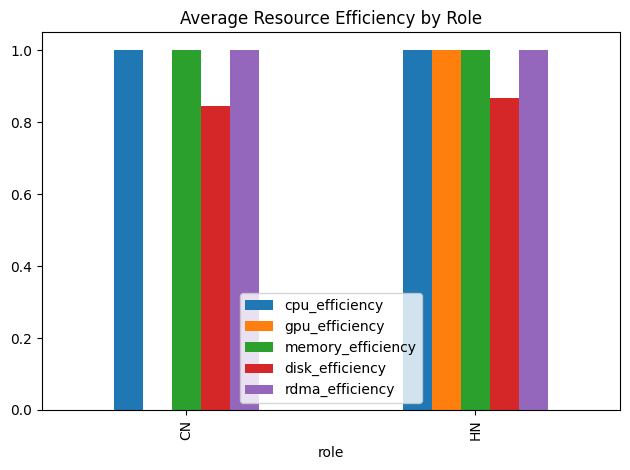

In [11]:
# Efficiency by role
role_efficiency = data.groupby("role")[[col for col in data.columns if "efficiency" in col]].mean()
print(role_efficiency)

# Efficiency by role
role_efficiency.plot(kind="bar", title="Average Resource Efficiency by Role")
plt.tight_layout()
plt.show()


### How do placement rules affect scheduling delay and runtime?
Instances with strict placement limits (2–4 instances per node) wait over 5min to be scheduled, while instances  with no limits (–1) or less limits (10–16) wait less, in seconds.

This shows that tighter constraints reduce scheduler flexibility and increase queueing delays. 

Runtime remains roughly stable across groups, suggesting placement rules mainly affect start time, not execution length.

In [12]:
# Group instances by max_instance_per_node and compute averages for each group
grouped = data.groupby("max_instance_per_node").agg(
    avg_delay=("scheduling_delay", "mean"),
    avg_runtime=("runtime", "mean"),
    count=("instance_sn", "count") #how many instances in the groups
).reset_index()

# Convert delay to minutes, runtime to hours
grouped["avg_delay_min"] = grouped["avg_delay"] / 60
grouped["avg_runtime_hr"] = grouped["avg_runtime"] / 3600
print(grouped)

   max_instance_per_node   avg_delay    avg_runtime  count  avg_delay_min  \
0                     -1   94.552977  109303.091206   9136       1.575883   
1                      2  318.138841   88948.236706   4624       5.302314   
2                      4  308.585440  108195.653558   2294       5.143091   
3                      8  205.018576   74617.937500    323       3.416976   
4                     10   42.243781  110797.666667    201       0.704063   
5                     16   29.769231  132697.833333     13       0.496154   

   avg_runtime_hr  
0       30.361970  
1       24.707844  
2       30.054348  
3       20.727205  
4       30.777130  
5       36.860509  


### Resampling and scaling resource features
Since the raw timestamps are in seconds, they are too noisy hence resampling to a 5-minute bucket to smooths out noise, enough to capture demand spikes.

Given the last 12 time steps (60 min/1hr worth of history), the model predicts the next time step, which corresponds to the next 5-minute interval of resource demand.

In [10]:
# Selecting and resample multiple features
features = ["cpu_request", "gpu_request", "rdma_request", "memory_request", "disk_request"]
data_resampled = data.set_index("creation_time")[features].resample("5T").sum() 

#Normalize all series
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_resampled)

#Turning the continuous series into input and output pairs.
def create_sequences_multivariate(series, seq_length):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])  # (seq_length, num_features)
        y.append(series[i+seq_length])    # predict all features at next step
    return np.array(X), np.array(y)

seq_length = 12 
X, y = create_sequences_multivariate(data_scaled, seq_length)


In [12]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5701, 12, 5)
X_test shape: (1782, 12, 5)
X_val shape: (1426, 12, 5)
y_val shape: (1426, 5)
y_train shape: (5701, 5)
y_test shape: (1782, 5)


### Building the LSTM model
Using a simple LSTM with one hidden layer and a dense output.

The training loss is very low compared to the validation loss which is higher, suggesting the model fits training data very well but then overfits.

In [14]:
model = Sequential([
    LSTM(32,
    activation='tanh',
    input_shape=(seq_length, X_train.shape[2])), #input use last 12 points
    Dense(X_train.shape[2])
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fit on the training set.
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],    
    verbose=0
)


# Print last training and validation loss
print("Final training loss:", history.history["loss"][-1])
print("Final validation loss:", history.history["val_loss"][-1])

Final training loss: 0.0008909178432077169
Final validation loss: 0.0021880469284951687


### How well did the model learn and generalize over epochs?
Below, training loss is much lower than validation loss, evidence of overfitting


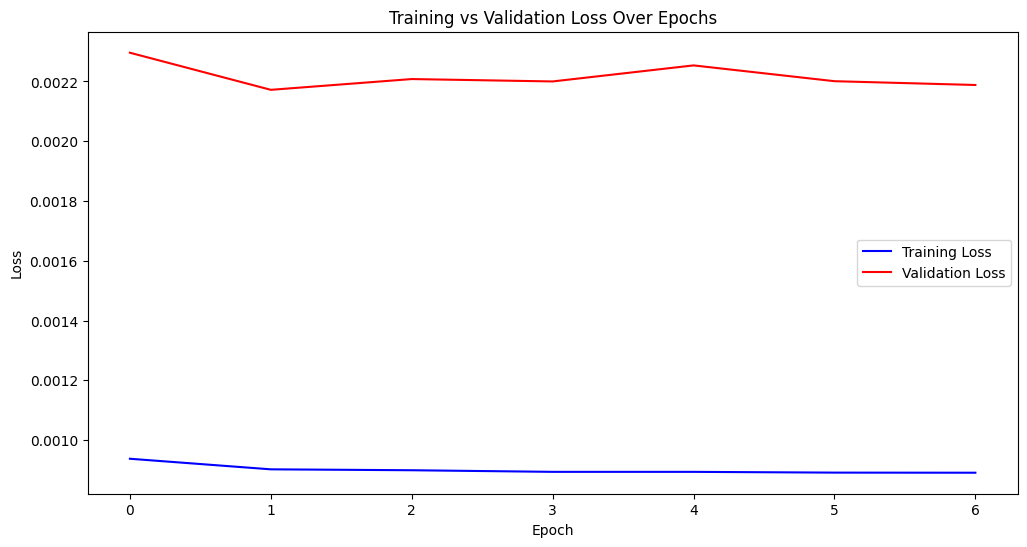

In [15]:
plt.figure(figsize=(12,6))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.title("Training vs Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### model’s predictions and evaluation on history


In [16]:
y_pred = model.predict(X_test)  

# inverse transform to original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
y_pred shape: (1782, 5)
y_test shape: (1782, 5)


### Evaluation results
While absolute errors, RMSE, MAE may appear large, the relative error (NRMSE), reveals that predictions are currently weak across all features, with errors two to six times larger than average values.

CPU, memory, and disk requests are better but still not good, compared to the rest(less NRMSE OF 2).

RDMA and GPU requests are the most difficult to forecast, with NRMSE larger, suggesting highly volatile patterns.

In [15]:
results = {}
for i, col in enumerate(features): 
    y_true = y_test_inv[:, i]
    y_pred_col = y_pred_inv[:, i]
    
    # Errors
    mse_i = mean_squared_error(y_true, y_pred_col)
    rmse_i = np.sqrt(mse_i)
    mae_i = mean_absolute_error(y_true, y_pred_col)
    
    # Mean + NRMSE
    mean_val = np.mean(y_true) # average magnitude of each feature/scale
    nrmse_i = rmse_i / mean_val if mean_val != 0 else np.nan
    
    results[col] = {
        "RMSE": rmse_i,
        "MAE": mae_i,
        "Mean Value": mean_val,
        "NRMSE": nrmse_i
    }

df_results = pd.DataFrame(results).T
print(df_results)

                       RMSE         MAE  Mean Value     NRMSE
cpu_request      246.609825  128.756484  106.219978  2.321690
gpu_request        3.190038    0.971317    0.517957  6.158881
rdma_request     120.740502   47.185124   23.848485  5.062816
memory_request  1248.672870  652.724965  534.371212  2.336714
disk_request    1100.669006  706.739749  504.791246  2.180444


### How well is the model predicting GPU requests over time?
The series is highly spiky, indicating GPU usage is very bursty and not smooth.

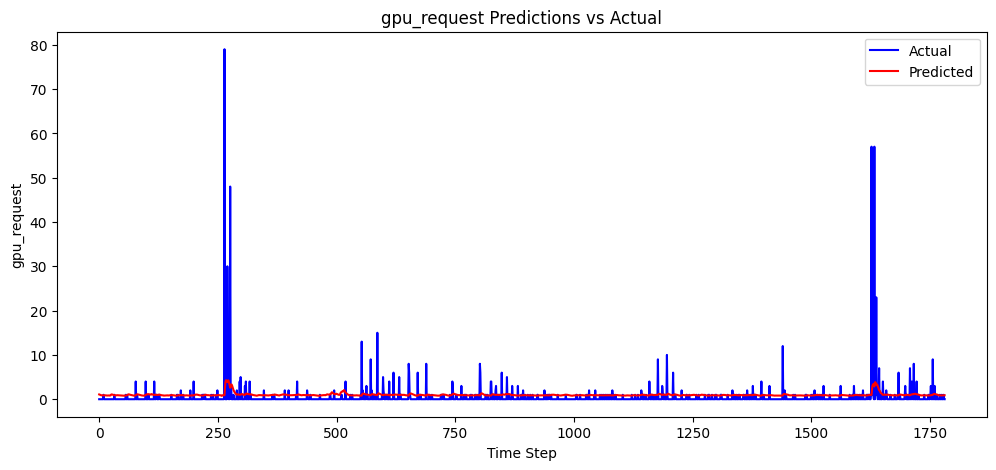

In [29]:
# Choosing one feature index, gpu_request
feature_idx = features.index("gpu_request")

plt.figure(figsize=(12,5))
plt.plot(y_test_inv[:, feature_idx], label="Actual", color="blue")
plt.plot(y_pred_inv[:, feature_idx], label="Predicted", color="red")
plt.title(f"{features[feature_idx]} Predictions vs Actual")
plt.xlabel("Time Step")
plt.ylabel(features[feature_idx])
plt.legend()
plt.show()

### Zoomed in GPU requests prediction
The model outputs a smoothed curve, staying around 0.2–0.5, completely missing the sudden spikes.

This explains why the NRMSE is so high (6.12) since the model underestimates peaks, **the model performs poorly on GPU requests**.

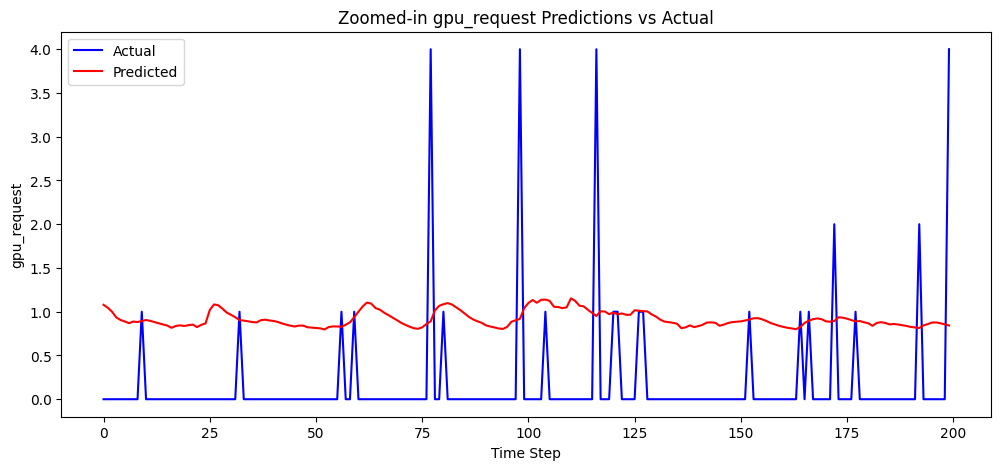

In [30]:
# Select first 200 time steps
start, end = 0, 200  

plt.figure(figsize=(12,5))
plt.plot(y_test_inv[start:end, feature_idx], label="Actual", color="blue")
plt.plot(y_pred_inv[start:end, feature_idx], label="Predicted", color="red")
plt.title(f"Zoomed-in {features[feature_idx]} Predictions vs Actual")
plt.xlabel("Time Step")
plt.ylabel(features[feature_idx])
plt.legend()
plt.show()

### What does total short term demand look like across  CPU, GPU, RDMA, memory and disk in the next 5 minutes?
Predict the next 5-minute demand for CPU, GPU, RDMA, memory, disk.

About 120 CPU units are expected to be requested in the next 5 minute window, less than 1 GPU on average, suggesting very low GPU activity in the next interval, likely very few GPU jobs scheduled. RDMA-enabled jobs are requesting about 57 units,hence instances with RDMA constraints are to be expected. Instances in the next 5 minutes are expected to request about 635 units of memory, and around 553 units of disk I/O/storage requested for indtsnces starting in the next 5 minute interval.

Overall, CPU, memory, and disk are showing significant load, while GPU demand is very minimal and RDMA demand is moderate.

In [19]:
# Taking the last 12 time steps with 5 features, from the full scaled dataset
last_sequence = data_scaled[-seq_length:]  
print("Last sequence shape:", last_sequence.shape)

# Reshape to match model input X-train(batch_size, seq_length, number of features)/one sequence (the most recent 12 timesteps)
last_sequence = last_sequence.reshape(1, seq_length, data_scaled.shape[1])

# Forecast next step (all features)
next_pred = model.predict(last_sequence)

# Inverse transform back to original scale
next_pred_inv = scaler.inverse_transform(next_pred)

# Feature order
features = ["cpu_request", "gpu_request", "rdma_request", "memory_request", "disk_request"]

# Wrap forecast into DataFrame
forecast_df = pd.DataFrame(next_pred_inv, columns=features)

print("Forecast for next 5 minutes:")
print(forecast_df.T)  # transpose so features show vertically


Last sequence shape: (12, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Forecast for next 5 minutes:
                         0
cpu_request     120.106796
gpu_request       0.435264
rdma_request     56.704239
memory_request  635.500488
disk_request    552.863464
